#1. 모델 읽어 오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from keras.models import load_model

model_path = '/content/drive/MyDrive/Colab Notebooks/Lec8_DeepLearning/2021_08_19_이미지분석2/models/cats_and_dogs_small_1.h5'
model = load_model(model_path)

#2. 그래프를 이용한 데이터 분석

##2.1 history 얻기

In [4]:
import numpy as np

history_path = '/content/drive/MyDrive/Colab Notebooks/Lec8_DeepLearning/2021_08_19_이미지분석2/models/my_history.npy'
history = np.load(history_path, allow_pickle='TRUE').item()
history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

##2.2 정확도 관련 그래프 분석

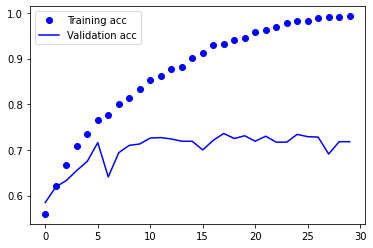

In [5]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']

epochs=range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend()

plt.show()

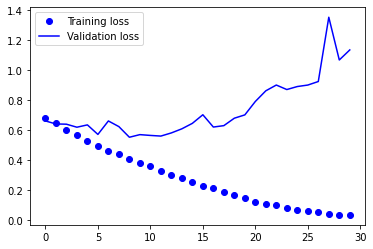

In [6]:
import matplotlib.pyplot as plt

loss = history['loss']
val_loss = history['val_loss']

epochs=range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()

plt.show()

#3. 데이터 증식
> 과적합은 학습할 샘플이 적어서 나타날 수 도 있다.
이러한 문제를 해결하기 위해, 기존 데이터에서 약간의 변화를 주어 샘플을 늘리는 방법이 데이터 증식이다.

## 3.1 ImageDataGenerator

In [11]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    # 이미지를 회전할 각도(0 ~ 180)
    rotation_range=40,

    #가로, 세로, 랜덤 이동
    width_shift_range=0.2,
    height_shift_range=0.2,

    #기울림 정도
    shear_range= 0.2,

    #확대, 축소
    zoom_range=0.2,

    #수평 대칭
    horizontal_flip=True,

    #픽셀 채우기
    fill_mode='nearest'
)

> fill_mode='constant', 'nearest', 'reflect', 'wrap'
- constant : kkkkkkkkkk|abcd|kkkkkkkkk
- nearest : aaaaaaaaaa|abcd|dddddddddd
- reflect : aabcddcba|abcd|dcbaabcd
- wrap : abcdabcdabcdabcd|abcd|abcdabcdabcd

##3.2 랜덤 이미지 확인
> generator를 이용해 만들어지는 이미지를 확인하기위한 챕터이며 분석 모델 작업시 생략해도 된다.

In [12]:
from keras.preprocessing import image
import os

train_cats_dir = '/content/drive/MyDrive/Colab Notebooks/Lec8_DeepLearning/2021_08_19_이미지분석2/cats_and_dogs/data/train/cats'
fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])
fnames[0]

'/content/drive/MyDrive/Colab Notebooks/Lec8_DeepLearning/2021_08_19_이미지분석2/cats_and_dogs/data/train/cats/cat.0.jpg'

> 경로 + 이미지명으로 데이터 정렬하여 저장

In [16]:
# 이미지 크기 변경
img = image.load_img(fnames[0], target_size=(150, 150))
print(img)

# 이미지를 배열로 변환
x = image.img_to_array(img)
x.shape

<PIL.Image.Image image mode=RGB size=150x150 at 0x7F7CA8368950>


(150, 150, 3)

In [17]:
x = x.reshape((1, )+x.shape)
x.shape

(1, 150, 150, 3)

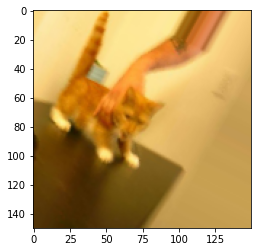

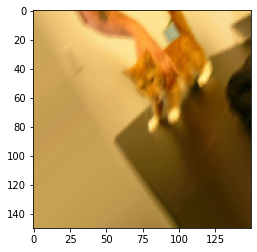

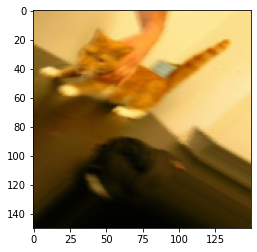

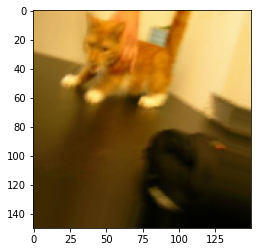

In [18]:
i=0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)

  imgplot = plt.imshow(image.array_to_img(batch[0]))

  i += 1
  if i%4 == 0:
    break

plt.show()

#4. Dropout
> 과적합을 배제하기 위해 layer에 몇몇 가중치를 0으로 처리함

In [19]:
from keras import models
from keras import layers

model = models.Sequential()

#hidden layer에 합성곱과 맥스 풀링 설정
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

# 1차원으로 변환
model.add(layers.Flatten())

# 입력 데이터의 50%의 노드를 무작위로 사용하지 않게 막는다.
model.add(layers.Dropout(0.5))

#결과 얻기
# 고양이와 개 중 하나를 고르는 것으로 sigmoid설정
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [22]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    # 이미지를 회전할 각도(0 ~ 180)
    rotation_range=40,

    #가로, 세로, 랜덤 이동
    width_shift_range=0.2,
    height_shift_range=0.2,

    #기울림 정도
    shear_range= 0.2,

    #확대, 축소
    zoom_range=0.2,

    #수평 대칭
    horizontal_flip=True,

    #픽셀 채우기
    fill_mode='nearest'
)

#검증 데이터는 증식을 사용하면 안됨
# 모델의 과적합을 막기 위한 기술임으로 검증에서는 당연히 배제되어야 함
test_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
path  = '/content/drive/MyDrive/Colab Notebooks/Lec8_DeepLearning/2021_08_19_이미지분석2/cats_and_dogs/data/'
train_dir = path + 'train'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.


In [25]:
path  = '/content/drive/MyDrive/Colab Notebooks/Lec8_DeepLearning/2021_08_19_이미지분석2/cats_and_dogs/data/'
validation_dir = path + 'validation'

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 1000 images belonging to 2 classes.


In [ ]:
#시간이 너무 오래걸려 진행했다 생각하고 패스
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

#모델 v2 불러오기

In [34]:
from keras.models import load_model

model_path = '/content/drive/MyDrive/Colab Notebooks/Lec8_DeepLearning/2021_08_19_이미지분석2/models/cats_and_dogs_small_v2.h5'
model = load_model(model_path)

In [35]:
import numpy as np

history_path = '/content/drive/MyDrive/Colab Notebooks/Lec8_DeepLearning/2021_08_19_이미지분석2/models/my_history_v2.npy'
history = np.load(history_path, allow_pickle='TRUE').item()
history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

## 모델v2 그래프 확인

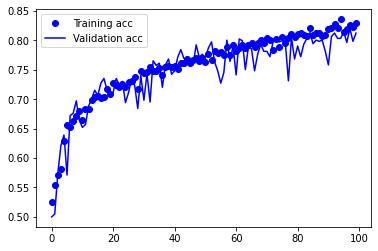

In [36]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']

epochs=range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend()

plt.show()

> Training acc와 Validation acc가 같이 가는것을 볼 수 있다. 

> 이를통해 과적합이 해소되었다고 생각 할 수 있다.

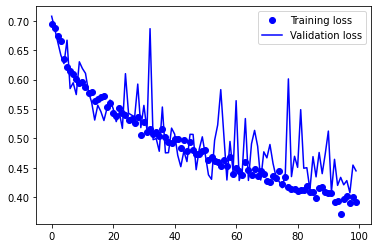

In [37]:
import matplotlib.pyplot as plt

loss = history['loss']
val_loss = history['val_loss']

epochs=range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()

plt.show()